# Focal Length Tuning for RealSense Camera

This notebook helps you find the optimal focal length for your RealSense camera to accurately reconstruct 3D point clouds into 2D projections. We'll:

1. Load your point cloud data
2. Try different focal length values
3. Visualize the projections side by side
4. Help you select the best focal length for your setup

In [8]:
import open3d as o3d
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets

# Load point cloud
pcd = o3d.io.read_point_cloud("d435.ply")  # Change to your point cloud file
points = np.asarray(pcd.points)
colors = np.asarray(pcd.colors)

if colors.shape[0] == 0:
    raise ValueError("Point cloud has no colors!")

print(f"Loaded point cloud with {len(points)} points")
print(f"Z value range: {points[:, 2].min()} to {points[:, 2].max()}")

# Visualize the raw point cloud
o3d.visualization.draw_geometries([pcd])

Loaded point cloud with 81669 points
Z value range: -3.72266 to -0.21582


In [ ]:
# Basic camera setup
img_width, img_height = 1280, 820
cx, cy = img_width // 2, img_height // 2

# Filter points in front of camera (adjust based on your coordinate system)
valid = points[:, 2] < 0  # Negative Z for RealSense camera
x, y, z = points[valid, 0], points[valid, 1], points[valid, 2]
colors_filtered = colors[valid]

print(f"Using {len(x)} points after filtering for negative Z")
print(f"Z range after filtering: {z.min()} to {z.max()}")

Using 81669 points after filtering for negative Z
Z range after filtering: -3.72266 to -0.21582


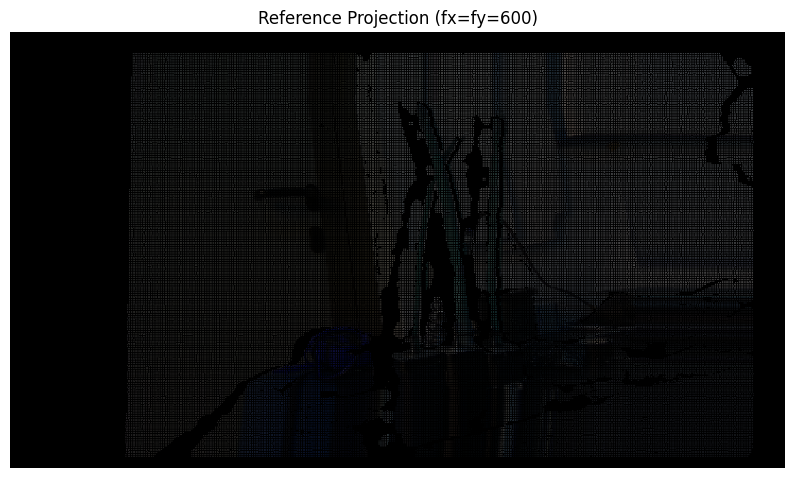

In [10]:
def create_projection(fx, fy, flip_x=True, flip_y=False):
    """
    Project 3D points to 2D image using the given focal lengths
    """
    # Perspective projection
    if flip_x:
        u = img_width - ((fx * x / z) + cx)
    else:
        u = (fx * x / z) + cx
        
    if flip_y:
        v = img_height - ((fy * y / z) + cy)
    else:
        v = (fy * y / z) + cy
        
    # Clip to image bounds
    u_img = np.clip(u, 0, img_width - 1).astype(int)
    v_img = np.clip(v, 0, img_height - 1).astype(int)
    
    # Create image
    image = np.zeros((img_height, img_width, 3), dtype=np.uint8)
    depth_buffer = np.full((img_height, img_width), -np.inf)  # For negative Z values
    
    # Project points
    for i in range(len(u_img)):
        ui, vi = u_img[i], v_img[i]
        zi = z[i]
        
        # For negative Z, larger values (less negative) are closer
        if zi > depth_buffer[vi, ui]:
            depth_buffer[vi, ui] = zi
            image[vi, ui] = (colors_filtered[i] * 255).astype(np.uint8)
    
    return image

# Create a reference image with current focal length
reference_image = create_projection(600, 600)
cv2.imwrite("reference_projection_fx600.png", cv2.cvtColor(reference_image, cv2.COLOR_RGB2BGR))

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB))
plt.title("Reference Projection (fx=fy=600)")
plt.axis('off')
plt.show()

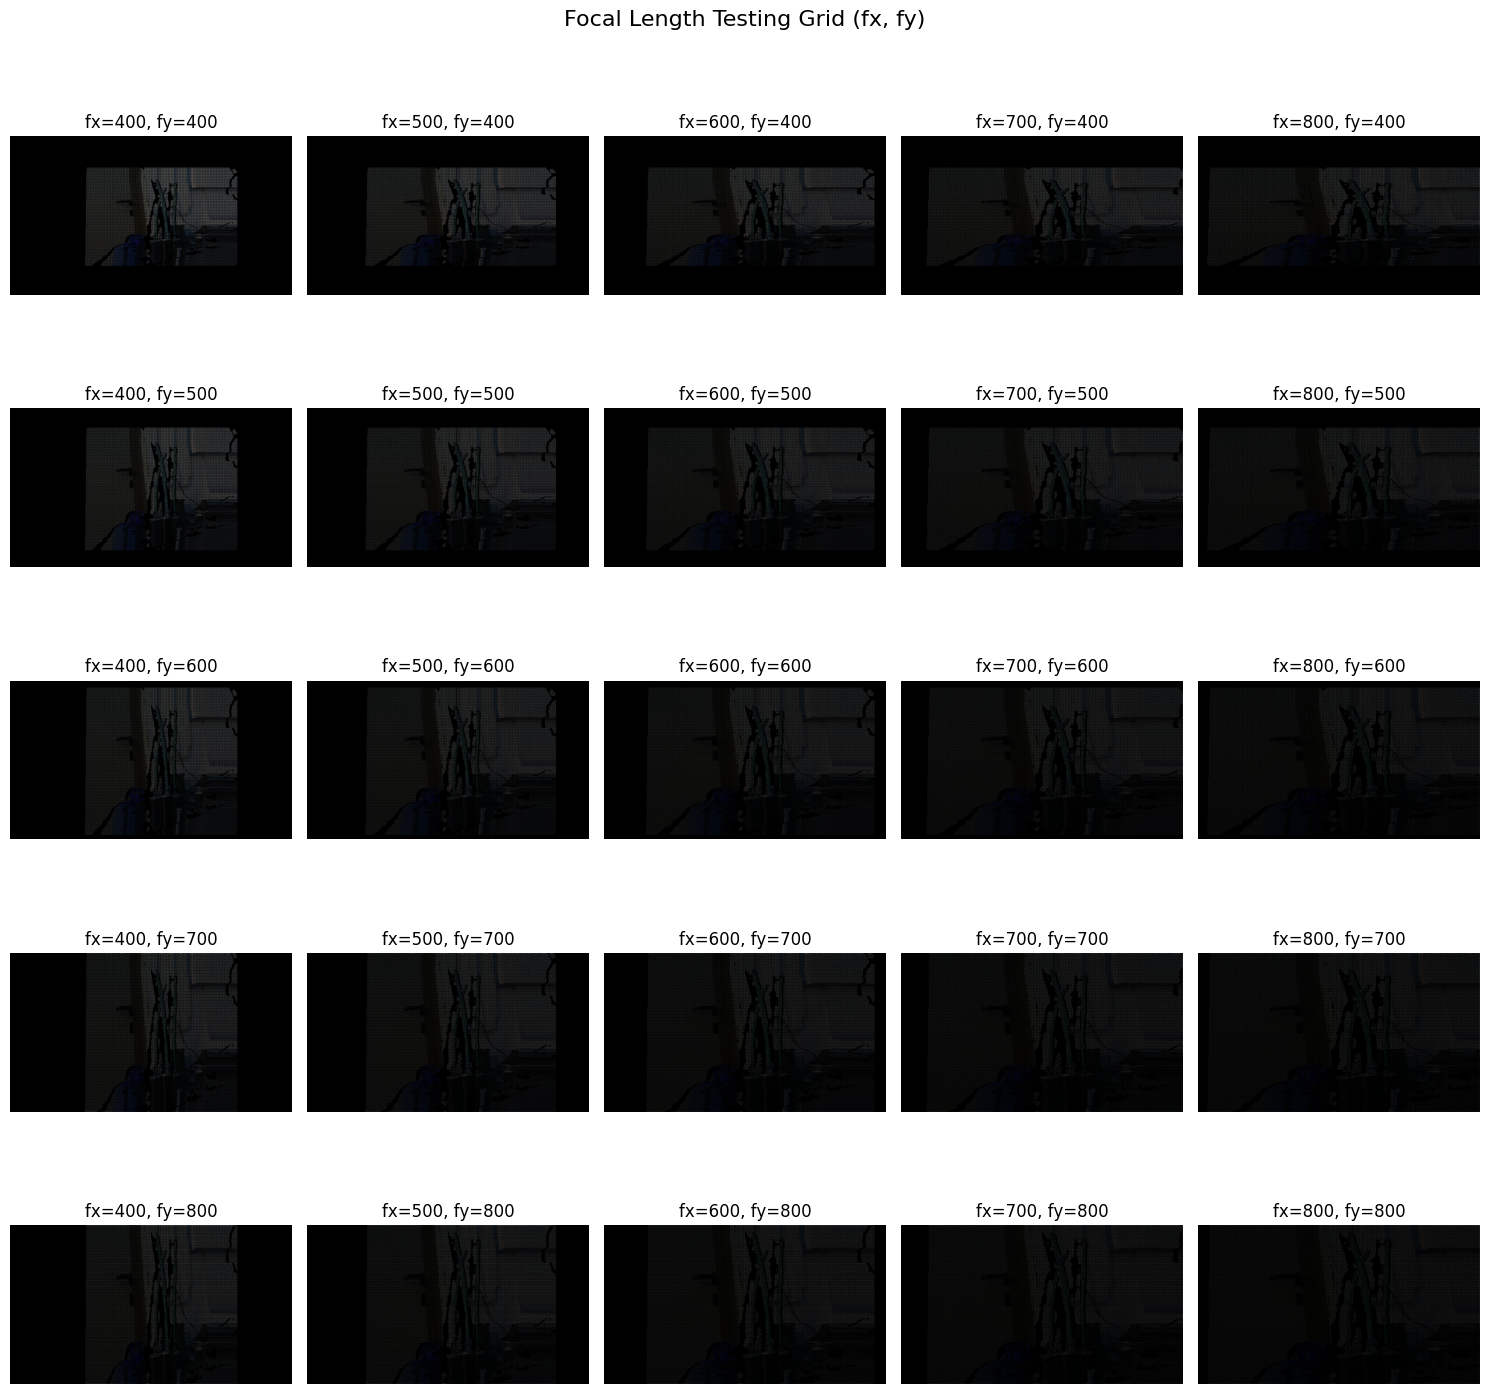

In [11]:
# Create a grid of focal length tests
fx_values = [400, 500, 600, 700, 800]
fy_values = [400, 500, 600, 700, 800]

fig, axes = plt.subplots(len(fy_values), len(fx_values), figsize=(15, 15))
fig.suptitle("Focal Length Testing Grid (fx, fy)", fontsize=16)

for i, fy in enumerate(fy_values):
    for j, fx in enumerate(fx_values):
        image = create_projection(fx, fy)
        axes[i, j].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[i, j].set_title(f"fx={fx}, fy={fy}")
        axes[i, j].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

In [6]:
# Interactive focal length tuning
@interact(
    fx=FloatSlider(min=300, max=1900, step=10, value=600, description='fx:'),
    fy=FloatSlider(min=300, max=1900, step=10, value=600, description='fy:'),
    flip_x=widgets.Checkbox(value=True, description='Flip X'),
    flip_y=widgets.Checkbox(value=False, description='Flip Y')
)
def update_projection(fx, fy, flip_x, flip_y):
    image = create_projection(fx, fy, flip_x, flip_y)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Projection with fx={fx}, fy={fy}")
    plt.axis('off')
    plt.show()
    
    return fx, fy, flip_x, flip_y

interactive(children=(FloatSlider(value=600.0, description='fx:', max=1900.0, min=300.0, step=10.0), FloatSlid…


# Update your code with these optimal values:

# ----------------------------
# 2. Camera Projection Setup
# ----------------------------
img_width, img_height = 1280, 720  # RealSense D435 default resolution
# RealSense D435 tuned parameters
fx, fy = 850, 850  # Tuned focal lengths
cx, cy = img_width // 2, img_height // 2  # Principal point (center of image)



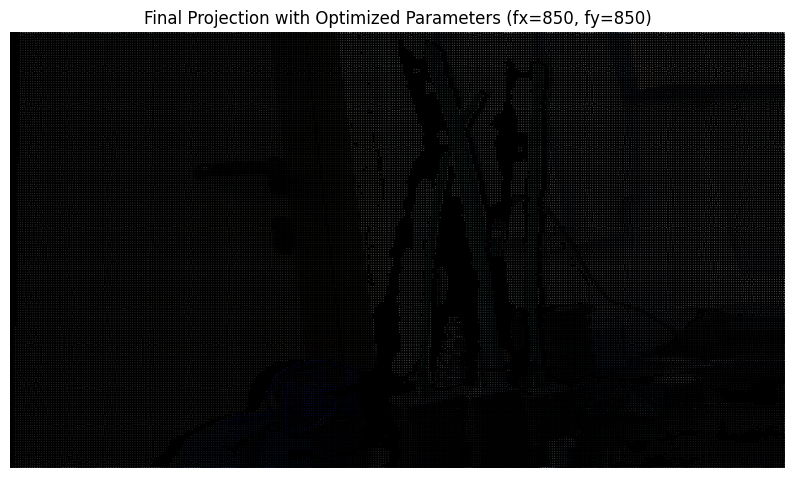

In [7]:
# Once you've found the ideal focal length:
# Update your main_maskfilter.py with these values

best_fx = 850  # Replace with your tuned value
best_fy = 850  # Replace with your tuned value

print(f"""
# Update your code with these optimal values:

# ----------------------------
# 2. Camera Projection Setup
# ----------------------------
img_width, img_height = 1280, 720  # RealSense D435 default resolution
# RealSense D435 tuned parameters
fx, fy = {best_fx}, {best_fy}  # Tuned focal lengths
cx, cy = img_width // 2, img_height // 2  # Principal point (center of image)
""")

# Create and save a final image with the best parameters
best_image = create_projection(best_fx, best_fy)
cv2.imwrite("optimal_projection.png", cv2.cvtColor(best_image, cv2.COLOR_RGB2BGR))

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(best_image, cv2.COLOR_BGR2RGB))
plt.title(f"Final Projection with Optimized Parameters (fx={best_fx}, fy={best_fy})")
plt.axis('off')
plt.show()

## How to Use the Tuned Focal Length

1. Find the values of `fx` and `fy` that produce the clearest projection of your asparagus stalks
2. Update your `main_maskfilter.py` with these values
3. If needed, adjust the X and Y flipping options as well
4. Re-run your point cloud projection to get more accurate results

### Note on RealSense Camera Calibration

For even better results, you can use the RealSense SDK to get the exact intrinsic parameters of your camera:

```python
import pyrealsense2 as rs

pipeline = rs.pipeline()
config = rs.config()
profile = pipeline.start(config)
intrinsics = profile.get_stream(rs.stream.color).as_video_stream_profile().get_intrinsics()

fx, fy = intrinsics.fx, intrinsics.fy
cx, cy = intrinsics.ppx, intrinsics.ppy
```

This will provide camera-specific calibration parameters rather than approximated values.